## Description

This notebook is for exploring and building the Monte Carlo architecture for Time Series prediction and risk assessment.

Main idea: Monte Carlo based hueristic for Time Series

In [171]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

from compstat_research.config import PROCESSED_DATA_DIR, MPLSTYLE_DIR

plt.style.use(MPLSTYLE_DIR / "iragca_cmr10.mplstyle")

### Loading data

Let's focus on building the architecture by using temperature for now. After we can compare the performance between different variables.

In [26]:
DATA_PATH = PROCESSED_DATA_DIR / "cds" / "era5" / "2m-temperature" / "global"

t2m_daily = pl.read_parquet(DATA_PATH / "era5-2m-temperature-global-daily-avg.parquet")

t2m_monthly = t2m_daily.group_by(["temp_year", "temp_month"]).agg(
    pl.col("avg_temp").mean().alias("t2m_mean")
).with_columns(
    comb=pl.datetime(pl.col("temp_year"), pl.col("temp_month"), pl.lit(1)).alias("date")

)
t2m_yearly = pl.read_parquet(DATA_PATH / "era5-2m-temperature-global-yearly-avg.parquet")

In [30]:
t2m_daily.head(2)

temp_year,temp_month,temp_day,avg_temp
i64,i64,i64,f64
1940,1,2,276.007051
1940,1,3,275.975732


<Axes: xlabel='temp_year', ylabel='avg_temp'>

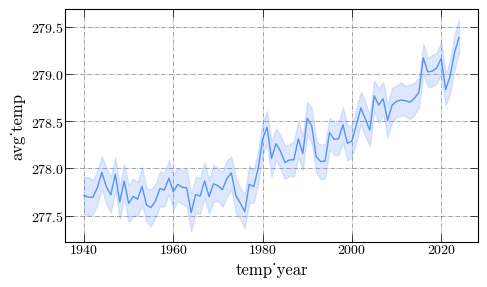

In [31]:
sns.lineplot(data=t2m_daily, x="temp_year", y="avg_temp")

<Axes: xlabel='comb', ylabel='t2m_mean'>

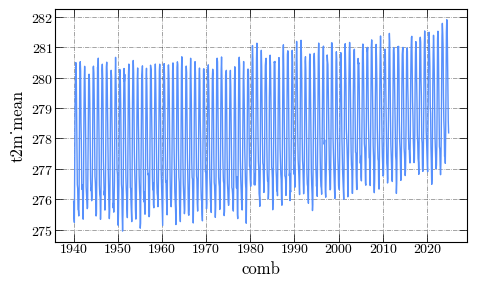

In [28]:
sns.lineplot(data=t2m_monthly, x="comb", y="t2m_mean")

<Axes: xlabel='temp_year', ylabel='avg_temp'>

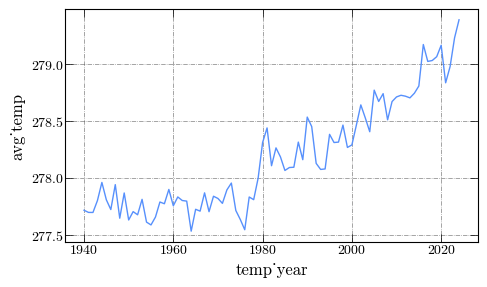

In [33]:
sns.lineplot(data=t2m_yearly, x="temp_year", y="avg_temp")

### Architecture

#### MonteCarloV1

In [ ]:
YEARS = np.arange(1940, 2025)

array([1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])

In [42]:
## Mean Functions

def harmonic_mean(x, y):
    return 2 / (1/x + 1/y)

def geometric_mean(x, y):
    return np.sqrt(x * y)

def arithmetic_mean(x, y):
    return (x + y) / 2

In [44]:
harmonic_mean(1, 2)

1.3333333333333333

In [49]:
BOUNDARY = 2000

X_train = t2m_yearly.filter(pl.col("temp_year") < BOUNDARY).select("temp_year").to_numpy()
y_train = t2m_yearly.filter(pl.col("temp_year") < BOUNDARY).select("avg_temp").to_numpy()

X_test = t2m_yearly.filter(pl.col("temp_year") >= BOUNDARY).select("temp_year").to_numpy()
y_test = t2m_yearly.filter(pl.col("temp_year") >= BOUNDARY).select("avg_temp").to_numpy()

In [63]:
# Create a pipeline (Polynomial Features + Linear Regression)
model = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())

# Train the model
model.fit(X_train, y_train)

# Predict values
y_pred = model.predict(X_test)

In [67]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(mean_squared_log_error(y_test, y_pred))

0.1484323021885234
0.03209278427065485
0.17914459040298944
4.0961041360431993e-07


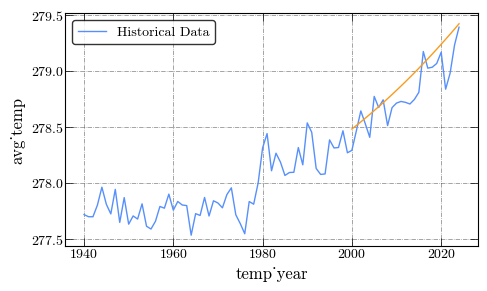

In [64]:
sns.lineplot(data=t2m_yearly, x="temp_year", y="avg_temp", label="Historical Data")
plt.plot(range(2000, 2025), y_pred, label="Prediction")

In [82]:
def selectyearsbefore(
    dataframe: pl.DataFrame, window: int, year: int, time_col: str, value_col: str
) -> pl.Series:
    """Returns the distribution of values for a given year and window size before that year.

    Args:
        dataframe (pl.DataFrame): _description_
        window (int): _description_
        year (int): _description_
        time_col (str): _description_
        value_col (str): _description_

    Returns:
        pl.Series: _description_
    """
    return dataframe.filter((pl.col(time_col) < year) & (pl.col(time_col) >= year - window))[
        value_col
    ]


selectyearsbefore(
    dataframe=t2m_yearly, window=20, year=2000, time_col="temp_year", value_col="avg_temp"
)

avg_temp
f64
278.309743
278.438068
278.105642
278.262564
278.18296
…
278.381534
278.309629
278.313399


In [83]:
np.random.choice(selectyearsbefore(
    dataframe=t2m_yearly, window=20, year=2000, time_col="temp_year", value_col="avg_temp"
))

np.float64(278.1262118866757)

In [138]:
def run_simulation(dataframe, year, window, pipeline, mean_function: callable, time_col, value_col):

        random_value = np.random.choice(
        selectyearsbefore(dataframe, window, year, time_col, value_col)
        )
        prediction = pipeline.predict([[year]]).flatten()

        return harmonic_mean(random_value, prediction)

In [142]:
run_simulation(t2m_yearly, 2030, 20, model, harmonic_mean, "temp_year", "avg_temp")

array([279.21814931])

In [172]:
simulations = []
for sim in tqdm(range(1000)):
    iteration_one = []
    for year in range(2000, 2025):
        iteration_one.append(run_simulation(t2m_yearly, year, 20, model, harmonic_mean, "temp_year", "avg_temp"))
    simulations.append(iteration_one)

100%|██████████| 1000/1000 [00:16<00:00, 61.32it/s]


In [193]:
from tqdm import tqdm

def run_simulations(num_simulations, start_year, end_year, t2m_yearly, model, harmonic_mean):
    simulations = []
    for sim in tqdm(range(num_simulations)):
        iteration_one = []
        for year in range(start_year, end_year):
            iteration_one.append(run_simulation(t2m_yearly, year, 40, model, harmonic_mean, "temp_year", "avg_temp"))
        simulations.append(iteration_one)
    return simulations

# Example usage
num_simulations = 1000
start_year = 1945
end_year = 2040
simulations = run_simulations(num_simulations, start_year, end_year, t2m_yearly, model, geometric_mean)

100%|██████████| 1000/1000 [01:00<00:00, 16.47it/s]


<Axes: xlabel='temp_year', ylabel='avg_temp'>

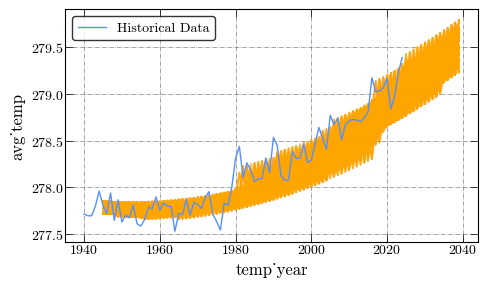

In [194]:
for sim in simulations:
    plt.plot(range(1945, 2040),sim, alpha=0.1, color="orange")

sns.lineplot(data=t2m_yearly, x="temp_year", y="avg_temp", label="Historical Data")

In [214]:
# Monte Carlo based heuristic


class MonteCarlo:

    def __init__(self, dataframe, pipeline, series, variable):
        self.dataframe = dataframe
        self.pipeline = pipeline
        self.series = series
        self.variable = variable

    class MeanFunction:
        @staticmethod
        def harmonic_mean(x, y):
            return 2 / (1 / x + 1 / y)

        @staticmethod
        def geometric_mean(x, y):
            return np.sqrt(x * y)

        @staticmethod
        def arithmetic_mean(x, y):
            return (x + y) / 2

    def _selectyearsbefore(
        self, dataframe: pl.DataFrame, window: int, year: int, time_col: str, value_col: str
    ) -> pl.Series:
        """Returns the distribution of values for a given year and window size before that year.

        Args:
            dataframe (pl.DataFrame): _description_
            window (int): _description_
            year (int): _description_
            time_col (str): _description_
            value_col (str): _description_

        Returns:
            pl.Series: _description_
        """
        return dataframe.filter((pl.col(time_col) < year) & (pl.col(time_col) >= year - window))[
            value_col
        ]

    def run_simulation(
        self,
        year,
        window,
        time_col,
        value_col,
        mean_function=None,
    ):
        if mean_function is None:
            mean_function = self.MeanFunction.harmonic_mean

        random_value = np.random.choice(
            self._selectyearsbefore(self.dataframe, window, year, time_col, value_col)
        )
        prediction = self.pipeline.predict([[year]]).flatten()

        return mean_function(random_value, prediction)

    def run_simulations(self, num_simulations, window, start_year, end_year, plot=True):
        simulations = []
        for sim in tqdm(range(num_simulations)):
            iteration_one = []
            for year in range(start_year, end_year):
                iteration_one.append(self.run_simulation(year, window, self.series, self.variable))
            simulations.append(iteration_one)

        if plot:
            self._plot_simulations(simulations)

        return simulations

    def _plot_simulations(self, simulations):
        for sim in simulations:
            plt.plot(range(1945, 2040), sim, alpha=0.1, color="orange", label="_nolegend_")

        sns.lineplot(data=self.dataframe, x=self.series, y=self.variable, label="Historical Data")

100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


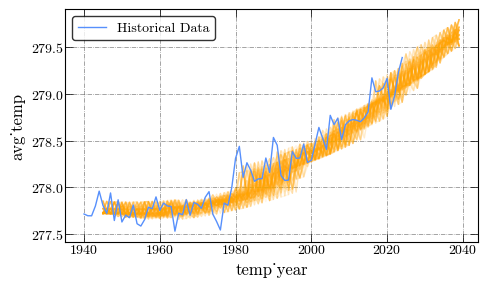

In [215]:
mc = MonteCarlo(t2m_yearly, model, "temp_year", "avg_temp")

simulations = mc.run_simulations(num_simulations=100, window=20, start_year=1945, end_year=2040)

#### MonteCarloV2

In [ ]:
class MonteCarloV2(MonteCarlo):
    # TODO: # Refit to model to the predict data

    def run_simulation(args):
        pass